# Transition Path

In this notebook, I solve and simulate the housing model along a **transition path** stemming from an interest rate shock

In [3]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy import optimize
from consav import linear_interp

# load the DurableConsumptionModel module
from HousingModel import HousingModelClass

# Set the number of threads in numba
nb.set_num_threads(4)

# Smoother
from scipy.signal import savgol_filter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test Relaxation Algorithm

This is to individually test each step in the relaxation algorithm for any troubleshooting

1. Define Reduced Form Supply function

In [13]:
# Write test function
def Hs_prime(x):
    
    # Parameters
    a = 9000
    b = 6.4593010477953685 - a*0.05
    
    # Set negatives to zero
    y = a*x + b
    
    return max(y,0)

2. Setup

In [66]:
# a. allocate
path_ph_ = np.zeros(model.par.path_T)
path_ph = np.zeros(model.par.path_T)

# b. setting
nu = 0.9995 # relaxation parameter
max_iter = 500 # maximum number of iterations

# Set path of prices
path_ph[:] = model.par.ph
model.par.path_ph[model.par.sim_T:model.par.sim_T+model.par.path_T] = path_ph

3. Solve and simulate along path - **start here again**

In [108]:
model.solve_path()
model.simulate_path()

4. Find implied house price

In [109]:
for t in range(model.par.path_T):
    path_ph_[t] = Hs_prime(np.mean(model.sim_path.d, axis=1)[model.par.sim_T+t])

5. Compute difference between implied and actual prices

In [110]:
max_abs_diff = np.max(np.abs(path_ph-path_ph_))
print(max_abs_diff)

49.0993239408949


Check results

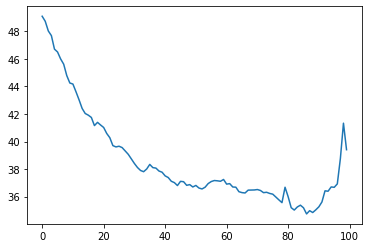

In [111]:
y = path_ph_ - path_ph
plt.plot(y)

6. Update price sequence

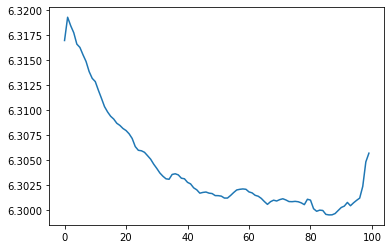

In [112]:
path_ph = nu*path_ph + (1-nu)*path_ph_
plt.plot(path_ph)

7. Add updated price sequence to model. **Then return to step 3**

In [113]:
model.par.path_ph[model.par.sim_T:model.par.sim_T+model.par.path_T] = path_ph

Test plot

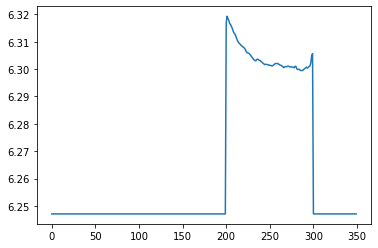

In [114]:
plt.plot(model.par.path_ph)

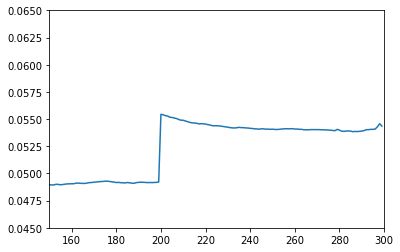

In [115]:
# define
h_path = np.mean(model.sim_path.d, axis=1)

# plot
plt.plot(range(len(h_path)),h_path)
plt.xlim(150,300)
plt.ylim(0.045,0.065)
plt.show()

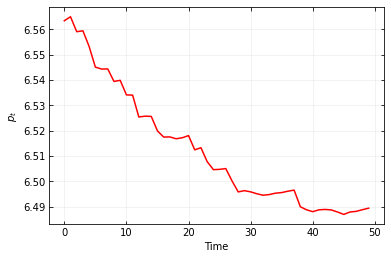

In [566]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(range(0,50),path_ph, color = 'red', label = 'Demand',zorder=2)

# ax.set_xlim(0.0,0.14)
# ax.set_ylim(2.5,9.4)
ax.set_xlabel('Time')
ax.set_ylabel(r'$p_t$')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

# plt.savefig('../../tex/figs/IRF_ph.pdf')

## Find Equilibrium Along a Transition Path

I apply a relaxation algorithm where I use a ghost run along the path as the benchmark to update equilibrium prices

In [5]:
# Define the model
model = HousingModelClass(name='example_negm',par={'solmethod':'negm', 'do_print':False})

# Solve and simulate
model.precompile_numba()
model.solve()
# model.simulate()

Ghost run - simulate path without abn interest rate drop

In [6]:
# No drop
model.par.R_drop = 0.0

# Solve and simulate along the path
model.solve_path()
model.simulate_path()

Check if everything looks reasonable

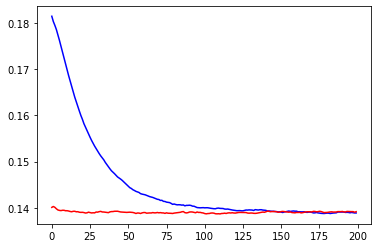

In [9]:
# Define aggregates
h_ss = np.mean(model.sim.d, axis=1)
h_path = np.mean(model.sim_path.d, axis=1)

# Plot results
plt.plot(h_ss, color ='blue')
plt.plot(h_path, color = 'red')
plt.show()

Looks fine!

In [10]:
# Define ghost run path
H_ghost = np.mean(model.sim_path.d, axis=1)

## Apply relaxation algorithm 

In [49]:
# Initialize model and solve initial steady state
model_path = HousingModelClass(name='example_negm',par={'solmethod':'negm', 'do_print':False})
model_path.precompile_numba()
model_path.solve()
model_path.simulate() # simulate initial ss

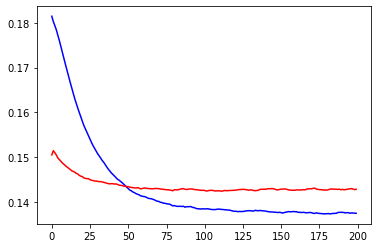

In [53]:
h_ss = np.mean(model_path.sim.d, axis=1)
h_path = np.mean(model_path.sim_path.d, axis=1)

# Plot results
plt.plot(h_ss, color ='blue')
plt.plot(h_path, color = 'red')
plt.show()

In [77]:
# a. allocate
path_ph = np.zeros(model_path.par.path_T + model_path.par.T)

# b. setting - 0.9999
nu = 2.0 # relaxation parameter
max_iter = 1000 # maximum number of iterations

# # c. Set path of prices
path_ph[:] = model_path.par.ph
model_path.par.path_ph = path_ph

# d. iterate
it = 0
for _ in range(max_iter):

    # ii. solve and simulate
    model_path.solve_path()
    model_path.simulate_path()

    # iii. Implied aggregate housing demand
    H = np.mean(model_path.sim_path.d, axis=1)
    
    # iv. difference
    max_abs_diff = np.max(np.abs(H[:-2] - H_ghost[:-2]))
    # if it%10 == 0: print(f'{it:4d}: {max_abs_diff:.8f}')
    if max_abs_diff < 10e-4: break # test different values of this threshold

    # v. update
    path_ph[:model_path.par.path_T] = path_ph[:model_path.par.path_T] + nu*(H - H_ghost)
    path_ph[model_path.par.path_T:] = path_ph[model_path.par.path_T-3]
    
    model_path.par.path_ph = path_ph    
    
    # vi.  increment
    it += 1
    if it > max_iter: raise Exception('too many iterations')    
    
    print(str(it)+'th iteration: dif = '+str(max_abs_diff))

1th iteration: dif = 0.011167044840519447
2th iteration: dif = 0.011193435416135072
3th iteration: dif = 0.010521676565212024
4th iteration: dif = 0.010175179631285836
5th iteration: dif = 0.009907851231054532
6th iteration: dif = 0.009673854165789031
7th iteration: dif = 0.009546919754343741
8th iteration: dif = 0.009434107212938775
9th iteration: dif = 0.009053097953141603
10th iteration: dif = 0.008153557865285072
11th iteration: dif = 0.007952816041153055
12th iteration: dif = 0.007776442977214193
13th iteration: dif = 0.007650678499544206
14th iteration: dif = 0.007278326037095828
15th iteration: dif = 0.006603380194647068
16th iteration: dif = 0.006163073517075596
17th iteration: dif = 0.005728135475721957
18th iteration: dif = 0.0054872089849804795
19th iteration: dif = 0.005138517196541764
20th iteration: dif = 0.005091067700641078
21th iteration: dif = 0.004690742735388415
22th iteration: dif = 0.004539000627066164
23th iteration: dif = 0.004382526108693635
24th iteration: dif

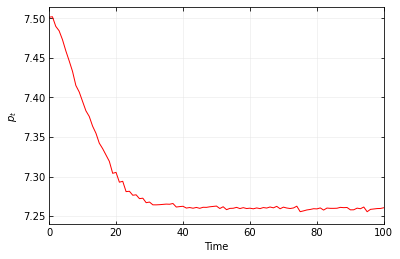

In [92]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(range(model_path.par.path_T),path_ph[:200], color = 'red', linestyle='-', linewidth=1,  label = 'Demand',zorder=2)
# ax.plot(range(model_path.par.path_T),yhat, color = 'red', linestyle='--', label = 'price', zorder=2)

ax.set_xlim(0,100)

ax.set_xlabel('Time')
ax.set_ylabel(r'$p_t$')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/IRF_ph.pdf')

In [109]:
c_path = np.zeros(10+model_path.par.path_T)
c_path[0:10] = np.mean(model_path.sim.c, axis=1)[-10:]
c_path[10:] = np.mean(model_path.sim_path.c, axis=1)

m_path = np.zeros(10+model_path.par.path_T)
m_path[0:10] = np.mean(model_path.sim.m, axis=1)[-10:]
m_path[10:] = np.mean(model_path.sim_path.m, axis=1)

t_axis = range(-10,200) # Time from shock

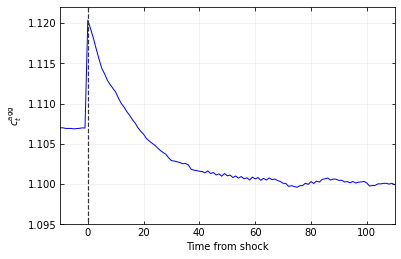

In [138]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, c_path, color = 'blue', linestyle='-', linewidth=1,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,110)
ax.set_ylim(1.095,1.122)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'$c^\mathrm{agg}_t$')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/IRF_c.pdf')

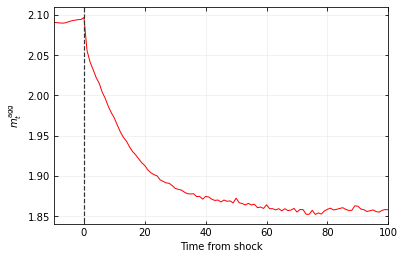

In [142]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, m_path, color = 'red', linestyle='-', linewidth=1,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,100)
ax.set_ylim(1.84,2.11)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'$m^\mathrm{agg}_t$')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

plt.savefig('../../tex/figs/IRF_m.pdf')